In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np

In [2]:
# 데이터셋 인스턴스 생성

data = pd.read_csv(r"C:\Users\tjdgu\CodingFiles\AI_Introduction\week6\diabetes.csv")  # CSV 파일 경로

In [3]:
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


<Axes: ylabel='count'>

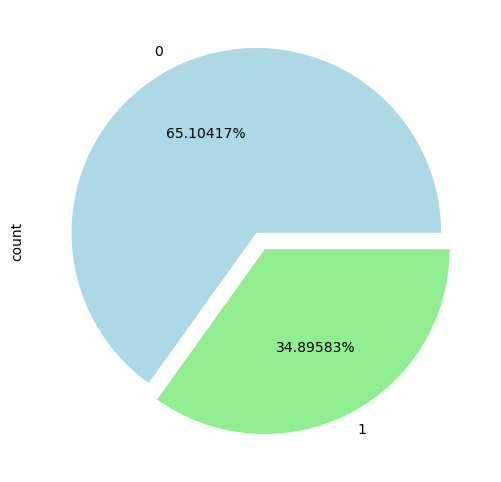

In [4]:
# 'Outcome' 0/1 비율 시각화
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
data.Outcome.value_counts().plot(kind='pie', autopct='%0.05f%%', colors=['lightblue', 'lightgreen', 'orange', 'pink'], explode=(0.05, 0.05))

In [5]:
# 데이터와 타겟 분리
X = data.drop('Outcome', axis=1).values
y = data['Outcome'].values

In [6]:
# 데이터 정규화
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 훈련 데이터, 테스트 데이터로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, 

((614, 8), (154, 8), (614,), (154,))

In [8]:
# 넘파이를 파이토치 텐서로 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)

In [9]:
# 데이터를 배치사이즈 만큼 꺼내줌
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 입력값, 정답값 하나로 묶기
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([614, 8]),
 torch.Size([154, 8]),
 torch.Size([614]),
 torch.Size([154]))

# 모델 정의

In [11]:
class DiabetesClassifier(nn.Module):
    def __init__(self):
        super(DiabetesClassifier, self).__init__()
        self.fc1 = nn.Linear(8, 64)     # 입력특성: 8개, 노드수: 64개
        self.fc2 = nn.Linear(64, 32)    # 노드수: 64 -> 32
        self.fc3 = nn.Linear(32, 2)  # 노드수: 32 -> 2(클래스 개수)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model = DiabetesClassifier()

# 손실 함수 및 최적화 기법 정의

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습

In [13]:
# 학습 중 손실값과 정확도 저장할 리스트
train_losses = []
test_accuracies = []

# 학습 반복 횟수 설정 (에폭 수)
num_epochs = 20

for epoch in range(num_epochs):
    model.train()  # 모델을 학습 모드로 설정
    running_loss = 0.0

    # 훈련용 데이터를 32개씩 나누어 학습
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()         # 매번 기울기 초기화
        outputs = model(inputs)       # 예측값 계산 (순전파)
        loss = criterion(outputs, labels)  # 예측값과 정답 비교해서 손실 계산
        loss.backward()               # 역전파: 손실을 기준으로 기울기 계산
        optimizer.step()              # 계산된 기울기로 가중치 업데이트

        running_loss += loss.item()   # 손실 누적

    # 한 에폭당 평균 손실 저장
    train_losses.append(running_loss / len(train_dataloader))

    # 테스트 데이터로 성능 평가
    model.eval()      # 평가 모드 전환
    correct = 0
    total = 0
    with torch.no_grad():  # 평가할 땐 기울기 계산 X (속도 ↑)
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)  # 예측 확률이 가장 높은 클래스 선택
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # 정확도 계산 (올바르게 예측한 수 / 전체 수)
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    # 에폭별 결과 출력
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")

Epoch 1/20, Loss: 0.6894, Accuracy: 72.73%
Epoch 2/20, Loss: 0.6212, Accuracy: 76.62%
Epoch 3/20, Loss: 0.5617, Accuracy: 80.52%
Epoch 4/20, Loss: 0.4934, Accuracy: 81.17%
Epoch 5/20, Loss: 0.4790, Accuracy: 79.22%
Epoch 6/20, Loss: 0.4594, Accuracy: 80.52%
Epoch 7/20, Loss: 0.4606, Accuracy: 79.87%
Epoch 8/20, Loss: 0.4446, Accuracy: 82.47%
Epoch 9/20, Loss: 0.4552, Accuracy: 79.87%
Epoch 10/20, Loss: 0.4489, Accuracy: 80.52%
Epoch 11/20, Loss: 0.4441, Accuracy: 82.47%
Epoch 12/20, Loss: 0.4446, Accuracy: 81.17%
Epoch 13/20, Loss: 0.4422, Accuracy: 81.17%
Epoch 14/20, Loss: 0.4395, Accuracy: 81.82%
Epoch 15/20, Loss: 0.4342, Accuracy: 81.17%
Epoch 16/20, Loss: 0.4412, Accuracy: 82.47%
Epoch 17/20, Loss: 0.4313, Accuracy: 81.82%
Epoch 18/20, Loss: 0.4292, Accuracy: 81.82%
Epoch 19/20, Loss: 0.4339, Accuracy: 81.82%
Epoch 20/20, Loss: 0.4155, Accuracy: 81.82%
Training complete.


# 모델 평가

In [14]:
# 평가 모드 전환
model.eval()

# 모든 예측값과 실제값을 담을 리스트
all_labels = []
all_predictions = []

# 테스트 데이터로 전체 예측 수행
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# 넘파이 배열로 변환
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# 혼동행렬 계산
conf_matrix = confusion_matrix(all_labels, all_predictions)

# 성능 지표 계산
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

# 각 클래스별 특이도 계산 (False Positive를 얼마나 잘 피했는가)
specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))

# 결과 출력
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')

Confusion Matrix:
[[95 12]
 [16 31]]
F1 Score: 0.82
Precision: 0.81
Recall: 0.82
Specificity: 0.77


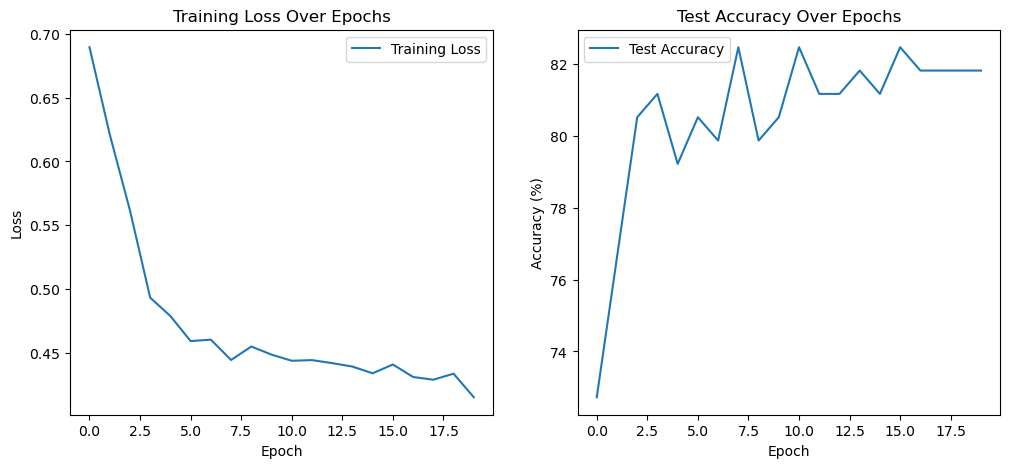

In [15]:
# 에폭(epoch)에 따른 손실과 정확도 시각화
plt.figure(figsize=(12, 5))  # 전체 그래프 크기 지정

# 왼쪽 그래프: 손실 변화
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# 오른쪽 그래프: 정확도 변화
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

# 그래프 출력
plt.show()